In [18]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Mouse C3KO-RichLi snRNA
####  2023-05-16 by Yi Zhao (Texas Heart Institute, US)
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Initiate  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
Ver <- '0'
Step <- 'PART06_Harmony'
Project <- '2023_neoc3ko_rli'

Code_dir <- paste0('/Volumes/shire/project/', Project, '/code/mouse_v', Ver, '/')

source(Sys.readlink(paste0(Code_dir, 'src/bioinformatics.R')))
source(Sys.readlink(paste0(Code_dir, 'src/scRNAseq.R')))
source(Sys.readlink(paste0(Code_dir, 'src/scATACseq.R')))
source(paste0(Code_dir, 'mouse_v', Ver, '.helper_functions.R'))

InitiateProject('Rivendell', Ver, Step, 'mouse', Project, 'shire')

suppressMessages(library('reticulate'))
suppressMessages(library('anndata'))
sc <- import("scanpy")
np <- import('numpy')
sce <- import('scanpy.external')

####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [19]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Global Functions  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
Preprocess <- function(srt_obj, assay = 'RNA', ...) {
        srt.out <- srt_obj |>
                NormalizeData(verbose = F) |>
                CellCycleScoring(s.features = s.genes, g2m.features = g2m.genes, set.ident = F) |>
                PercentageFeatureSet(pattern = '^mt-', col.name = paste0('pct_mito_', assay), assay = assay)
        srt.out@meta.data[, paste0('pct_mito_', assay)][is.nan(srt.out@meta.data[, paste0('pct_mito_', assay)])] <- 0
        return(srt.out)
}

RunUMAP.my <- function(srt_obj, var.toal = 0.75, haromize.by, assay, ...){
        srt.out <- RunPCA(srt_obj, seed.use = 505, assay = assay)
        dimN <- FindDimNumber(srt_obj = srt.out, var.toal = var.toal, reduction = 'pca')
        srt.out <- RunUMAP(srt.out, dims = 1:dimN, seed.use = 505) |>
                RunHarmony(group.by.vars = haromize.by, assay.use = assay)
        dimN <- FindDimNumber(srt_obj = srt.out, var.toal = var.toal, reduction = 'harmony')
        srt.out <- RunUMAP(srt.out, dims = 1:dimN, seed.use = 505, reduction = 'harmony',
                           reduction.name = 'hmn_umap', reduction.key = 'hmnumap_', ...)
        srt.out <- FindNeighbors(srt.out, reduction = "harmony", dims = 1:dimN) %>% FindClusters(resolution = seq(0.2, 1.6, 0.2), verbose = FALSE)
        return(srt.out)
}
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----

In [20]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Load data  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
srt <- readRDS('integrated/PART05.merged.clean_cbn.srt.rds')
DefaultAssay(srt) <- 'RNA'
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [21]:
colnames(srt@meta.data)

[1] "nCount_RNA"       "nFeature_RNA"     "sample"           "orig.name"       
 [5] "study"            "method"           "platform"         "protocol"        
 [9] "processed"        "tissue"           "enrichment"       "genotype"        
[13] "condition"        "sex"              "age"              "replicate"       
[17] "S.Score"          "G2M.Score"        "Phase"            "pct_mito_RNA"    
[21] "group1"           "group2"           "data_process"     "LowQual"         
[25] "Doublet_SC"       "Doublet_SC_score"

In [22]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Visualize data  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
## Preprocess
assay <- 'RNA'
srt <- Preprocess(srt,assay)
srt <- FindVariableFeatures(srt) |> ScaleData(vars.to.regress = c('nCount_RNA', 'nFeature_RNA','S.Score', 'G2M.Score', 'pct_mito_RNA'))

srt <- RunUMAP.my(srt, assay = assay, var.toal = 0.75, haromize.by = 'sample')
gc()

Regressing out nCount_RNA, nFeature_RNA, S.Score, G2M.Score, pct_mito_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Col1a1, Col3a1, Col1a2, Fth1, Msln, Upk3b, Rarres2, Efemp1, Upk1b, Gpc3 
	   Serping1, Dcn, Lrrn4, Fbln1, Muc16, Nkain4, C1s1, Igfbp6, S100a6, Sema3d 
	   Adgrd1, Rplp1, Hpgd, Rplp0, Lgals1, Krt19, Aebp1, Sparc, Rps3a1, Rpsa 
Negative:  Emcn, Pecam1, St6galnac3, Nrxn3, Flt1, Hmcn1, Eng, Egfl7, Ramp2, Ctla2a 
	   Tie1, Calcrl, Ece1, Rgs3, Pgm5, Cemip2, Ptprb, Rps6ka2, Vwf, Rasgef1b 
	   Prkch, Igf2, Cd93, Plvap, Cdh5, Nos3, Elk3, Smoc1, Col23a1, Dock9 
PC_ 2 
Positive:  Gpm6a, Pkhd1l1, Sulf1, Bicc1, Cdh11, Wdr17, Gpc3, Sema3d, Efemp1, Slit3 
	   Muc16, Adgrd1, Upk1b, Msln, Upk3b, Gpr39, Sema3c, Sox5, Hpgd, Col5a2 
	   Dpp4, Arhgap28, Il1rapl1, Gm12840, Dcn, Bnc2, Rarres2, Cdon, Rspo1, Zbtb7c 
Negative:  Myl2, Myl3, Fabp3, Actc1, Atp5g1, Mb, Cox6c, Tnni3, Gapdh, Slc25a4 
	   Ndufa4, Cox4i1, Atp5o, Uqcr11, Cox5b, Atp5g3, Atp5h, Cox6b1, Atp5e, Uqcrq 
	   Cox5a, Co

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,15248400,814.4,27528714,1470.2,NA,27528714,1470.2
Vcells,1692061288,12909.5,3242516427,24738.5,131072,3047827494,23253.1


In [23]:
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
####  Check meta and dimensions  ####
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~----
plist <- list()

dr <- c('hmn_umap')
plist[[1]] <- DimPlot2(srt, group.by = 'group1', cols = mycol_10, reduction = dr)
plist[[2]] <- DimPlot2(srt, group.by = 'Doublet_SC', cols = mycol_10, reduction = dr)


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



In [24]:
p1 <- wrap_plots(plist[[1]], ncol = 2)
p2 <- wrap_plots(plist[[2]], ncol = 2)
PlotPDF('01.umap.by_sample_by_doublet', 20, 20)
p1
p2
dev.off()

pdf 
  2

In [26]:
plist <- list()

dr <- c('hmn_umap')
plist[[1]] <- DimPlot2(srt, group.by = 'RNA_snn_res.0.2', cols = mycol_20, reduction = dr,
                                    label = T, repel = T)
plist[[2]] <- DimPlot2(srt, group.by = 'RNA_snn_res.0.4', cols = mycol_20, reduction = dr,
                                    label = T, repel = T)
plist[[3]] <- DimPlot2(srt, group.by = 'RNA_snn_res.0.8', cols = mycol_30, reduction = dr,
                                    label = T, repel = T)
plist[[4]] <- DimPlot2(srt, group.by = 'RNA_snn_res.1', cols = mycol_40, reduction = dr,
                                    label = T, repel = T)
plist[[5]] <- DimPlot2(srt, group.by = 'RNA_snn_res.1.4', cols = mycol_50, reduction = dr,
                                    label = T, repel = T)

p1 <- wrap_plots(plist[[1]], ncol = 3)
p2 <- wrap_plots(plist[[2]], ncol = 3)
p3 <- wrap_plots(plist[[3]], ncol = 3)
p4 <- wrap_plots(plist[[4]], ncol = 3)
p5 <- wrap_plots(plist[[5]], ncol = 3)

PlotPDF('02.umap.harmony', 22, 16)
p1
p2
p3
p4
p5
dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



pdf 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



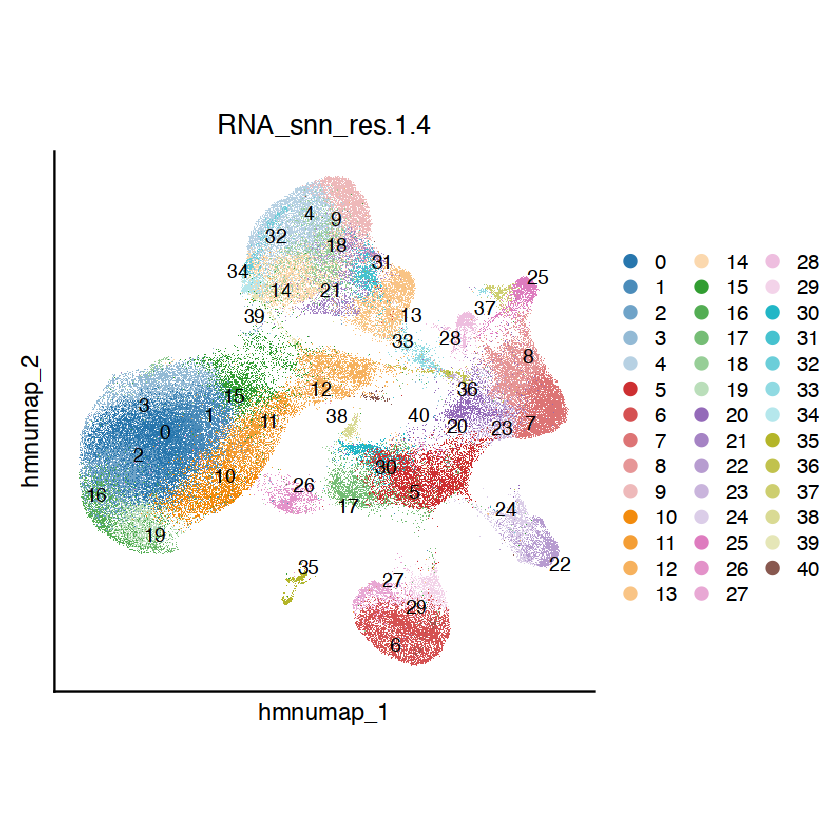

In [27]:
DimPlot2(srt, group.by = 'RNA_snn_res.1.4', cols = mycol_50, reduction = dr,
                                    label = T, repel = T)

In [28]:
#srt <- DietSeurat(srt, assays = names(srt@assays),dimreducs = c('scVI_umap', 'scVI'))
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [29]:
saveRDS(srt, 'integrated/PART06.harmony_integration_clustered.srt.rds')
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [30]:
PlotPDF('03.dotplot.c3', 6, 12)
DotPlot2(srt, features = c('C3','Upk3b','Col1a1'),group.by = 'RNA_snn_res.0.4',split.by = 'genotype',cols = 'RdYlBu')
dev.off()

pdf 
  2